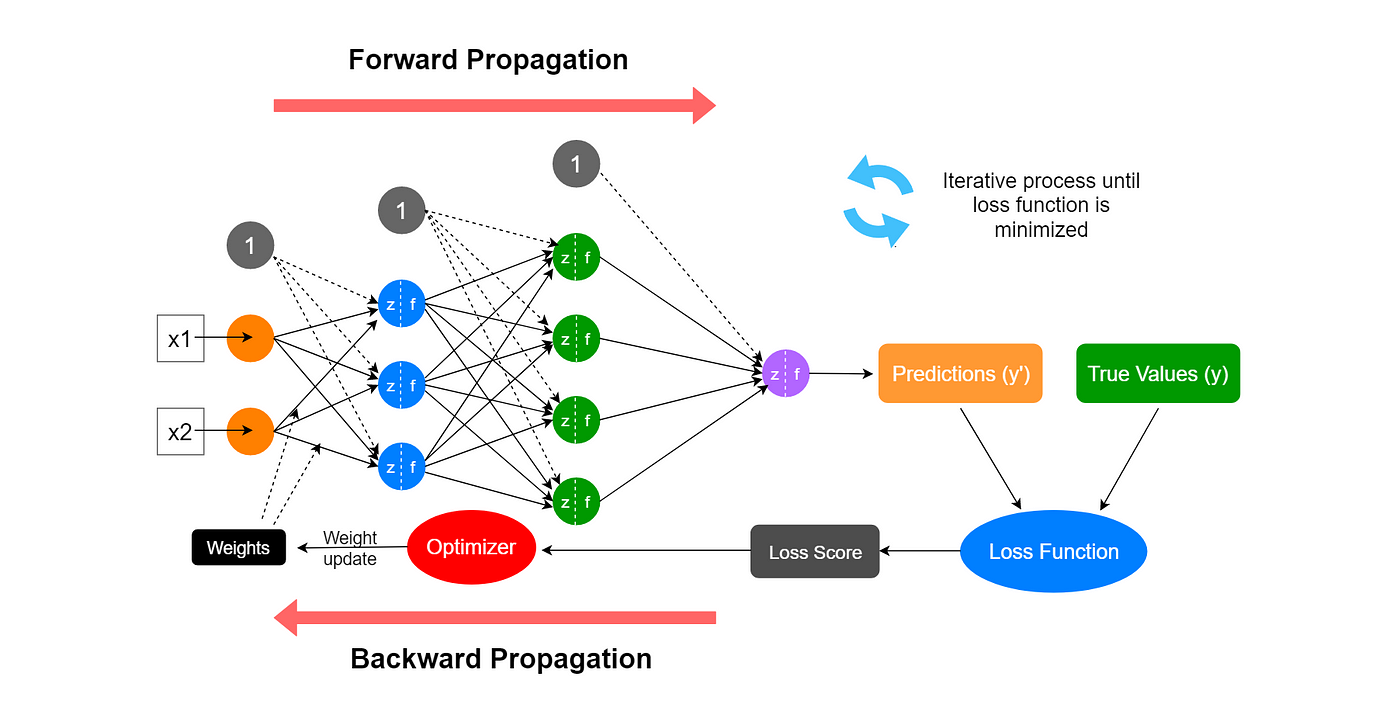
https://medium.com/@xsankalp13/a-beginners-guide-to-neural-networks-forward-and-backward-propagation-explained-a814666c73ab for more ref.

### **Key Variables:**
- self.layers: Stores the layers of the neural network.
- self.errors: Tracks training and validation errors for monitoring.
- self.val_set: Holds validation data if provided.

### **Summary of Key Methods**

| **Method**          | **Description**                                                                 |
|----------------------|---------------------------------------------------------------------------------|
| `add(layer)`         | Adds a new layer to the network.                                               |
| `fit()`              | Trains the network on the dataset for multiple epochs by splitting the data into   batches and updating weights for each batch using 1. Forward pass to calculate the output of the network and 2. Backward pass to Propagate the loss backward and updates weights.                        |
| `_forward_pass()`    | Propagates input data through the network.                                    |
| `_backward_pass()`   | Updates weights by backpropagating the loss gradient.                         |
| `train_on_batch()`   | Performs one training step on a batch of data.                                |
| `test_on_batch()`    | Evaluates the model's performance on a batch of data without updating weights. |
| `predict()`          | Generates predictions for new input data.                                     |
| `summary()`          | Provides a detailed summary of the network architecture.                      |

In [30]:
from __future__ import print_function, division
from terminaltables import AsciiTable
import numpy as np
import progressbar
bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()]
def batch_iterator(X, y=None, batch_size=64):
    """ Simple batch generator """
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]


In [31]:
class NeuralNetwork():
    """Neural Network. Deep Learning base model.

    Parameters:
    -----------
    optimizer: class
        The weight optimizer that will be used to tune the weights in order of minimizing
        the loss.
    loss: class
        Loss function used to measure the model's performance. SquareLoss or CrossEntropy.
    validation: tuple
        A tuple containing validation data and labels (X, y)
    """
    def __init__(self, optimizer, loss, validation_data=None):
        self.optimizer = optimizer
        self.layers = []
        self.errors = {"training": [], "validation": []}
        self.loss_function = loss()
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        self.val_set = None
        if validation_data:
            X, y = validation_data
            self.val_set = {"X": X, "y": y}

    def set_trainable(self, trainable):
        """ Method which enables freezing of the weights of the network's layers. """
        for layer in self.layers:
            layer.trainable = trainable

    def add(self, layer):
        """ Method which adds a layer to the neural network """
        # If this is not the first layer added then set the input shape
        # to the output shape of the last added layer
        if self.layers:
            layer.set_input_shape(shape=self.layers[-1].output_shape())

        # If the layer has weights that needs to be initialized 
        if hasattr(layer, 'initialize'):
            layer.initialize(optimizer=self.optimizer)

        # Add layer to the network
        self.layers.append(layer)

    def test_on_batch(self, X, y):
        """ Evaluates the model over a single batch of samples """
        y_pred = self._forward_pass(X, training=False)
        loss = np.mean(self.loss_function.loss(y, y_pred))
        acc = self.loss_function.acc(y, y_pred)

        return loss, acc

    def train_on_batch(self, X, y):
        """ Single gradient update over one batch of samples """
        y_pred = self._forward_pass(X)
        loss = np.mean(self.loss_function.loss(y, y_pred))
        acc = self.loss_function.acc(y, y_pred)
        # Calculate the gradient of the loss function wrt y_pred
        loss_grad = self.loss_function.gradient(y, y_pred)
        # Backpropagate. Update weights
        self._backward_pass(loss_grad=loss_grad)

        return loss, acc

    def fit(self, X, y, n_epochs, batch_size):
        """ Trains the model for a fixed number of epochs """
        for _ in self.progressbar(range(n_epochs)):
            
            batch_error = []
            for X_batch, y_batch in batch_iterator(X, y, batch_size=batch_size):
                loss, _ = self.train_on_batch(X_batch, y_batch)
                batch_error.append(loss)

            self.errors["training"].append(np.mean(batch_error))

            if self.val_set is not None:
                val_loss, _ = self.test_on_batch(self.val_set["X"], self.val_set["y"])
                self.errors["validation"].append(val_loss)

        return self.errors["training"], self.errors["validation"]

    def _forward_pass(self, X, training=True):
        """ Calculate the output of the NN """
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward_pass(layer_output, training)

        return layer_output

    def _backward_pass(self, loss_grad):
        """ Propagate the gradient 'backwards' and update the weights in each layer """
        for layer in reversed(self.layers):
            loss_grad = layer.backward_pass(loss_grad)

    def summary(self, name="Model Summary"):
        # Print model name
        print (AsciiTable([[name]]).table)
        # Network input shape (first layer's input shape)
        print ("Input Shape: %s" % str(self.layers[0].input_shape))
        # Iterate through network and get each layer's configuration
        table_data = [["Layer Type", "Parameters", "Output Shape"]]
        tot_params = 0
        for layer in self.layers:
            layer_name = layer.layer_name()
            params = layer.parameters()
            out_shape = layer.output_shape()
            table_data.append([layer_name, str(params), str(out_shape)])
            tot_params += params
        # Print network configuration table
        print (AsciiTable(table_data).table)
        print ("Total Parameters: %d\n" % tot_params)

    def predict(self, X):
        """ Use the trained model to predict labels of X """
        return self._forward_pass(X, training=False)